In [1]:
# import sys
# !{sys.executable} -m pip install python3

In [2]:
import os
import pandas as pd
# from pyspark import SparkContext, SparkConf
# from pyspark.sql import SparkSession
# from pyspark.sql.types import StructType
# from pyspark.sql.functions import col

---

In [3]:
os.environ["HADOOP_USER_NAME"] = "hdfs"
os.environ["PYTHON_VERSION"] = "3.6"

In [4]:
# # init spark session

# conf = SparkConf()
# conf.setAppName('Lecture HDFS').setMaster('local[*]')
# spark = SparkContext(conf=conf)


In [5]:
# sparkSession = SparkSession.builder.appName("pyspark_test").getOrCreate()


In [6]:
# spark


---

In [7]:
from pyspark.sql import SparkSession

#sans se connecter au cluster
#spark = SparkSession.builder.getOrCreate()

spark = SparkSession.\
        builder.\
        appName("pyspark-notebook").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "1g").\
        getOrCreate()

22/11/16 01:10:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [8]:
# lecture des données
# path = 'hdfs://localhost:9000/Donnees/objets-trouves-restitution.csv'
path = './Donnees/objets-trouves-restitution.csv'
# df = sparkSession.read.format("csv").option("header", "true").load(path,delimiter=';')
# df = sparkSession.read.format("csv").option("header", "true").load(path)
df = spark.read.load(path, format="csv", header = True,delimiter=';')

In [9]:
df

DataFrame[Date: string, Date et heure de restitution: string, Gare: string, Code UIC: string, Nature d'objets: string, Type d'objets: string, Type d'enregistrement: string]

In [10]:
df.dtypes

[('Date', 'string'),
 ('Date et heure de restitution', 'string'),
 ('Gare', 'string'),
 ('Code UIC', 'string'),
 ("Nature d'objets", 'string'),
 ("Type d'objets", 'string'),
 ("Type d'enregistrement", 'string')]

In [11]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Date et heure de restitution: string (nullable = true)
 |-- Gare: string (nullable = true)
 |-- Code UIC: string (nullable = true)
 |-- Nature d'objets: string (nullable = true)
 |-- Type d'objets: string (nullable = true)
 |-- Type d'enregistrement: string (nullable = true)



---

In [12]:
# on renomme compte le nombre d'elements de chaque nature et o nomme cette colonne < countTrouvé >
new_df = df.groupBy(["Nature d'objets"]).count().orderBy('count', ascending=False).withColumnRenamed("count","countTrouve")


In [13]:
new_df.show(5)

+--------------------+-----------+
|     Nature d'objets|countTrouve|
+--------------------+-----------+
|Porte-monnaie, po...|      68638|
|           Sac à dos|      61922|
|  Téléphone portable|      58858|
|Valise, sac sur r...|      51312|
|Manteau, veste, b...|      49050|
+--------------------+-----------+
only showing top 5 rows



In [14]:
# On sauvegarde le fichier avec la nouvelle colonne countTrouve
# new_df.write.format("csv").save( "Spark_output/objets-trouves__1.csv")

---

In [15]:
new_df_copy_10 = new_df.take(10)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [17]:
df = pd.DataFrame (new_df_copy_10, columns = ['NatureObjet','countTrouv'])

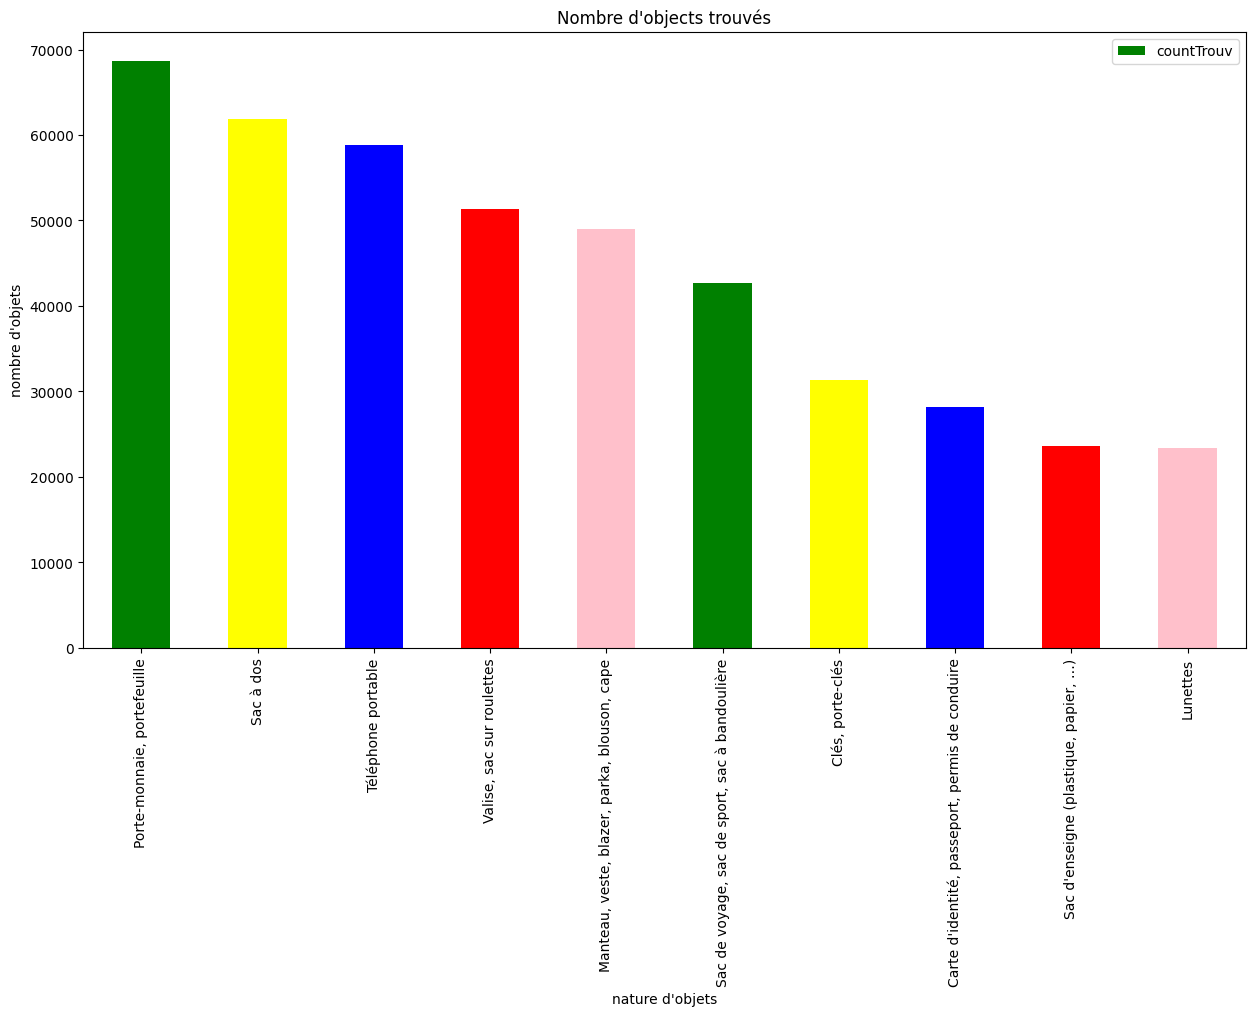

In [18]:
df.plot(x="NatureObjet",y="countTrouv",kind='bar',color=['green','yellow','blue','red','pink'], figsize=(15, 8) ) ;

plt.title("Nombre d'objects trouvés")
plt.xlabel("nature d'objets")
plt.ylabel("nombre d'objets")
plt.show()

---

In [19]:
# import saved csv
spark_path = "Spark_output/objets-trouves"
df1 = spark.read.format("csv").option("header", "true").load(path, delimiter=';')

In [20]:
from pyspark.sql import functions as F
# df.select(F.col("my_column"))
df2objetRestitued = df1.filter(F.col("Date et heure de restitution").isNotNull())
# df2objetRestitued = df1.filter(df1("Date et heure de restitution").isNotNull())

In [21]:
mylistRest = df2objetRestitued.groupBy(["Nature d'objets"]).count().orderBy('count', ascending=False).withColumnRenamed("count","countRes")

In [22]:
mylistRest.show(5)

+--------------------+--------+
|     Nature d'objets|countRes|
+--------------------+--------+
|Porte-monnaie, po...|   36163|
|Valise, sac sur r...|   32561|
|           Sac à dos|   31606|
|  Téléphone portable|   25227|
|Sac de voyage, sa...|   21807|
+--------------------+--------+
only showing top 5 rows



In [23]:
# mylistRest.write.format("csv").save("Spark_output/objetsrestitues_1.csv")

In [24]:
# Jointure entre les deux liste
myListJoined = mylistRest.join(new_df,["Nature d'objets"])

In [25]:
myListJoined.show()

+--------------------+--------+-----------+
|     Nature d'objets|countRes|countTrouve|
+--------------------+--------+-----------+
|  Autres jeux/jouets|      72|        510|
|Cigarette électro...|       7|         92|
|Autres articles m...|     294|        932|
|Autres articles d...|     914|       3785|
|      Jeu de société|      14|        116|
|           Après-ski|       3|         13|
|Disque dur extern...|     177|       1205|
|          Skateboard|     217|        642|
|Attaché-case, ser...|    2054|       3528|
|    Pull over, gilet|     641|       9049|
|           Sac à dos|   31606|      61922|
|       Autres bijoux|      18|        222|
|  Appareils auditifs|      43|        246|
|     Chemise à rabat|     863|       1964|
|Porte-monnaie, po...|   36163|      68638|
|Sac d'enseigne (p...|    6916|      23656|
|        Club de golf|      38|         58|
|  Téléphone portable|   25227|      58858|
|Pièce d'identité ...|    2504|      10519|
|  Housse de vêtement|     243| 

In [26]:
from pyspark.sql import functions as F


In [27]:
from pyspark.sql.types     import FloatType
from pyspark.sql.functions import udf

@udf(returnType = FloatType())
def dif(col1, col2):
    return (col1 * 100) / col2

In [28]:
# le pourcentage d'objet restituées 
myListJoined=myListJoined.withColumn("Pourcentage",dif("countRes","countTrouve")).orderBy('Pourcentage', ascending=False)

In [29]:
myListJoined.show()

+--------------------+--------+-----------+-----------+
|     Nature d'objets|countRes|countTrouve|Pourcentage|
+--------------------+--------+-----------+-----------+
|              Violon|     130|        166|  78.313255|
|Appareils respira...|     147|        200|       73.5|
|Ordinateur, ordin...|    2330|       3260|   71.47239|
|               Flûte|      38|         54|   70.37037|
|Ordinateur, ordin...|    5765|       8497|   67.84747|
|        Club de golf|      38|         58|   65.51724|
|Valise, sac sur r...|   32561|      51312|   63.45689|
|             Guitare|     462|        734|   62.94278|
|Autres instrument...|     501|        832|  60.216347|
|          Sac à main|   11026|      18403|  59.914143|
|Sacoche pour ordi...|    2752|       4672|   58.90411|
|Attaché-case, ser...|    2054|       3528|  58.219955|
|Sacoche ventrale,...|    3585|       6160|   58.19805|
|Téléphone portabl...|    8119|      14077|   57.67564|
|  Housse de vêtement|     243|        429|  56.

In [30]:
# Le fichier qui contient les objets déclarés perdu
path1  ='./Donnees/objets-trouves-gares.csv'

In [31]:
# df3 = spark.read.format("csv").option("header", "true").load(path1,delimiter=';')
df3 = spark.read.load(path1, format="csv", header = True, delimiter=';')

In [32]:
df3.dtypes

[('Date de la déclaration de perte', 'string'),
 ('Gare', 'string'),
 ('Code UIC', 'string'),
 ("Nature d'objets", 'string'),
 ("Type d'objets", 'string'),
 ("Type d'enregistrement", 'string')]

In [33]:
df3.show()

+-------------------------------+-------------------+----------+--------------------+--------------------+---------------------+
|Date de la déclaration de perte|               Gare|  Code UIC|     Nature d'objets|       Type d'objets|Type d'enregistrement|
+-------------------------------+-------------------+----------+--------------------+--------------------+---------------------+
|            2019-05-24T18:52:18|          Paris Est|0087113001|Manteau, veste, b...|Vêtements, chauss...| Déclaration de Perte|
|            2019-05-24T18:53:32|               null|      null|  Téléphone portable|Appareils électro...| Déclaration de Perte|
|            2019-05-24T19:00:58|               null|      null|Sac de voyage, sa...|Bagagerie: sacs, ...| Déclaration de Perte|
|            2019-05-24T19:09:28|               null|      null|Autre pièce ou pa...|Pièces d'identité...| Déclaration de Perte|
|            2019-05-24T19:11:10| Paris Saint-Lazare|0087384008|Sacoche ventrale,...|Bagagerie: s

In [34]:
mylistDec = df3.groupBy(["Nature d'objets"]).count().orderBy('count', ascending=False).withColumnRenamed("count","countDec")

In [35]:
mylistDec.show()

+--------------------+--------+
|     Nature d'objets|countDec|
+--------------------+--------+
|Porte-monnaie, po...|  136609|
|           Sac à dos|  113851|
|  Téléphone portable|  111741|
|Valise, sac sur r...|   96396|
|Manteau, veste, b...|   88029|
|Sac de voyage, sa...|   75146|
|    Clés, porte-clés|   57990|
|Carte d'identité,...|   49573|
|Sac d'enseigne (p...|   43331|
|       Autres divers|   43010|
|            Lunettes|   42941|
|    Lunettes en étui|   39667|
|          Sac à main|   36754|
|Téléphone portabl...|   35344|
|Ordinateur, ordin...|   30302|
|Autres appareils ...|   26369|
|     Bonnet, chapeau|   26291|
|  Carte d'abonnement|   22859|
|     Autre bagagerie|   20769|
|    Foulard, écharpe|   18782|
+--------------------+--------+
only showing top 20 rows



In [36]:
myListJoinedDecRes = mylistDec.join(new_df,["Nature d'objets"])

In [37]:
myListJoinedDecRes.show()
# Reste a voir comment visualiser tout ça

+--------------------+--------+-----------+
|     Nature d'objets|countDec|countTrouve|
+--------------------+--------+-----------+
|  Autres jeux/jouets|    1010|        510|
|Cigarette électro...|     156|         92|
|Appareil photo, c...|       8|          1|
|Autres articles m...|    1933|        932|
|Autres articles d...|   14796|       3785|
|      Jeu de société|     338|        116|
|           Après-ski|      48|         13|
|Disque dur extern...|    7530|       1205|
|          Skateboard|    1641|        642|
|Attaché-case, ser...|    8750|       3528|
|    Pull over, gilet|   13353|       9049|
|           Sac à dos|  113851|      61922|
|       Autres bijoux|     981|        222|
|  Appareils auditifs|    1310|        246|
|     Chemise à rabat|    5215|       1964|
|Porte-monnaie, po...|  136609|      68638|
|Sac d'enseigne (p...|   43331|      23656|
|        Club de golf|     127|         58|
|  Téléphone portable|  111741|      58858|
|Pièce d'identité ...|   17784| 

#Transform the Date from a string to a timestamp (Date)

#Relation entre les declaration de perte et la régularité mensuelle

In [38]:
from pyspark.sql.functions import *

In [39]:
df4 = df3.withColumn('perteTime', F.col('Date de la déclaration de perte').cast("timestamp"))

In [40]:
df4.dtypes

[('Date de la déclaration de perte', 'string'),
 ('Gare', 'string'),
 ('Code UIC', 'string'),
 ("Nature d'objets", 'string'),
 ("Type d'objets", 'string'),
 ("Type d'enregistrement", 'string'),
 ('perteTime', 'timestamp')]

In [41]:
df4.show(1,truncate=False)

+-------------------------------+---------+----------+--------------------------------------------+---------------------+---------------------+-------------------+
|Date de la déclaration de perte|Gare     |Code UIC  |Nature d'objets                             |Type d'objets        |Type d'enregistrement|perteTime          |
+-------------------------------+---------+----------+--------------------------------------------+---------------------+---------------------+-------------------+
|2019-05-24T18:52:18            |Paris Est|0087113001|Manteau, veste, blazer, parka, blouson, cape|Vêtements, chaussures|Déclaration de Perte |2019-05-24 18:52:18|
+-------------------------------+---------+----------+--------------------------------------------+---------------------+---------------------+-------------------+
only showing top 1 row



In [42]:
df4.printSchema

<bound method DataFrame.printSchema of DataFrame[Date de la déclaration de perte: string, Gare: string, Code UIC: string, Nature d'objets: string, Type d'objets: string, Type d'enregistrement: string, perteTime: timestamp]>

In [43]:
df4 = df4.withColumn("year",year(col("perteTime")))
df4 = df4.withColumn("month",month(col("perteTime")))
df4 = df4.withColumn("hour",hour(col("perteTime")))
df4 = df4.withColumn("minute",minute(col("perteTime")))

Pour ce traitemant on va d'abord se focaliser sur un mois précis et puis on va regarder les intervalles des horaires

In [44]:
df4.show(1,truncate=False)

+-------------------------------+---------+----------+--------------------------------------------+---------------------+---------------------+-------------------+----+-----+----+------+
|Date de la déclaration de perte|Gare     |Code UIC  |Nature d'objets                             |Type d'objets        |Type d'enregistrement|perteTime          |year|month|hour|minute|
+-------------------------------+---------+----------+--------------------------------------------+---------------------+---------------------+-------------------+----+-----+----+------+
|2019-05-24T18:52:18            |Paris Est|0087113001|Manteau, veste, blazer, parka, blouson, cape|Vêtements, chaussures|Déclaration de Perte |2019-05-24 18:52:18|2019|5    |18  |52    |
+-------------------------------+---------+----------+--------------------------------------------+---------------------+---------------------+-------------------+----+-----+----+------+
only showing top 1 row



In [45]:
donneAnneprecis = df4.where(col("year") == '2019')
donneMoisprecis = donneAnneprecis.where(col("month") == '5')

In [46]:
donneMoisprecis.show(10)

+-------------------------------+------------------+----------+--------------------+--------------------+---------------------+-------------------+----+-----+----+------+
|Date de la déclaration de perte|              Gare|  Code UIC|     Nature d'objets|       Type d'objets|Type d'enregistrement|          perteTime|year|month|hour|minute|
+-------------------------------+------------------+----------+--------------------+--------------------+---------------------+-------------------+----+-----+----+------+
|            2019-05-24T18:52:18|         Paris Est|0087113001|Manteau, veste, b...|Vêtements, chauss...| Déclaration de Perte|2019-05-24 18:52:18|2019|    5|  18|    52|
|            2019-05-24T18:53:32|              null|      null|  Téléphone portable|Appareils électro...| Déclaration de Perte|2019-05-24 18:53:32|2019|    5|  18|    53|
|            2019-05-24T19:00:58|              null|      null|Sac de voyage, sa...|Bagagerie: sacs, ...| Déclaration de Perte|2019-05-24 19:00:5

In [47]:
donneMoisprecis = donneMoisprecis.orderBy('hour','minute', ascending = True)

In [48]:
donneMoisprecis.show(10)

+-------------------------------+----+--------+--------------------+--------------------+---------------------+-------------------+----+-----+----+------+
|Date de la déclaration de perte|Gare|Code UIC|     Nature d'objets|       Type d'objets|Type d'enregistrement|          perteTime|year|month|hour|minute|
+-------------------------------+----+--------+--------------------+--------------------+---------------------+-------------------+----+-----+----+------+
|            2019-05-15T00:00:25|null|    null|Carte d'identité,...|Pièces d'identité...| Déclaration de Perte|2019-05-15 00:00:25|2019|    5|   0|     0|
|            2019-05-03T00:00:45|null|    null|Sac de voyage, sa...|Bagagerie: sacs, ...| Déclaration de Perte|2019-05-03 00:00:45|2019|    5|   0|     0|
|            2019-05-02T00:00:11|null|    null|Tablette tactile ...|Appareils électro...| Déclaration de Perte|2019-05-02 00:00:11|2019|    5|   0|     0|
|            2019-05-02T00:00:30|null|    null|       Autres divers|  

In [49]:
listInterval = []
listNumber = []
for i in range(22):
    a = donneMoisprecis.where(col("hour").between(i,i+2)).count()
    chaine = "["+str(i)+','+str(i+2)+"]"
    listInterval.append(chaine)
    listNumber.append(a)

In [50]:
MyDataMonth5 = pd.DataFrame(list(zip(listInterval,listNumber)), columns = ['Interval de temps','Nombres objets perdus'])

In [51]:
# Dans ce dataFrame on peut voir le nombre d'objet perdu entre diff intervalle de temps exemple entre 0h et 2h 
# on a 277 déclaration de perte 
MyDataMonth5

,Interval de temps,Nombres objets perdus
0,"[0,2]",277
1,"[1,3]",99
2,"[2,4]",59
3,"[3,5]",46
4,"[4,6]",107
5,"[5,7]",312
6,"[6,8]",1091
7,"[7,9]",2250
8,"[8,10]",3310
9,"[9,11]",3749


<AxesSubplot: xlabel='Interval de temps'>

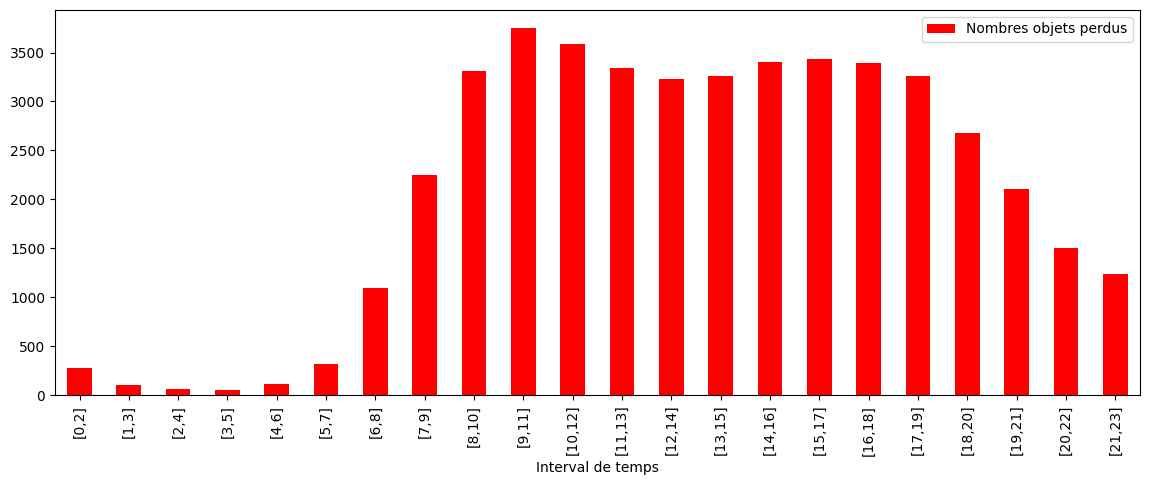

In [52]:
MyDataMonth5.plot.bar(x='Interval de temps',y='Nombres objets perdus',figsize=(14, 5),color="red")

<AxesSubplot: xlabel='Interval de temps'>

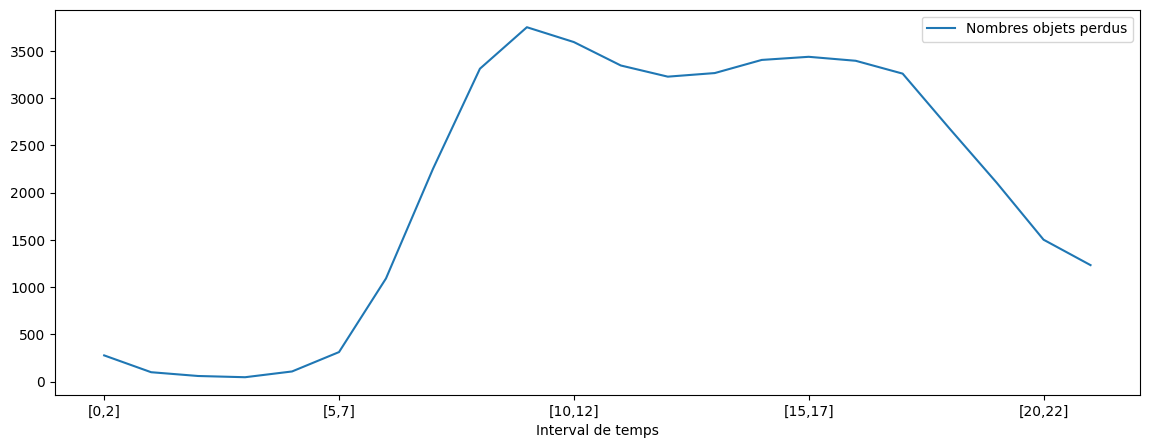

In [53]:
MyDataMonth5.plot.line(x='Interval de temps',y='Nombres objets perdus',figsize=(14, 5))

<AxesSubplot: xlabel='Interval de temps', ylabel='Nombres objets perdus'>

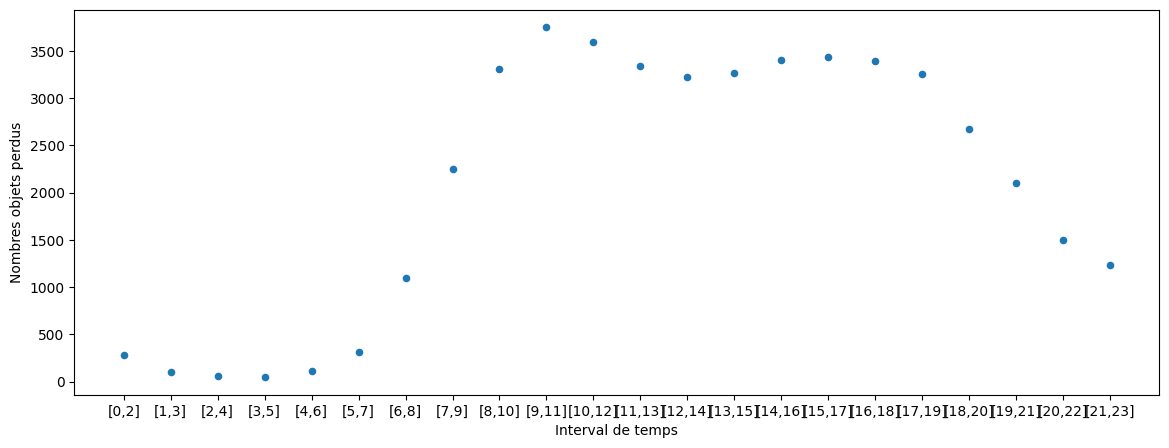

In [54]:
MyDataMonth5.plot.scatter(x='Interval de temps',y='Nombres objets perdus',figsize=(14, 5))

In [55]:
# Le fichier qui contient la régularité mensuelle des trains
path2  ="./Donnees/regularite-mensuelle-intercites.csv"

In [56]:
# trainsM = spark.read.format("csv").option("header", "true").load(path2,delimiter=';')
trainsM = spark.read.load(path2, format="csv", header = True,delimiter=';')

In [57]:
trainsM =trainsM.withColumn("date_timestamp",to_timestamp(col("date"),"yyyy-MM"))

In [58]:
trainsM = trainsM.withColumn("year",year(col("date_timestamp")))
trainsM = trainsM.withColumn("month",month(col("date_timestamp")))

In [59]:
trainAnneprecis = trainsM.where(col("year") == '2019')

In [60]:
trainAnneprecis.write.format("csv").save("/home/datacreapper/Bureau/ProjectBigDataVis/Données/Donnees/trainMoisprecis_")

In [61]:
# d'abord on doit transformé le taux_de_régularité de string vers numerique
trainAnneprecis = trainAnneprecis.withColumn("taux_de_regularite",col("taux_de_regularite").cast('float'))

In [62]:
# j'ai défini une fonction regul 
@udf(returnType = FloatType())
def regul(tauxRegul):
    return 100 - tauxRegul

In [63]:
mydataTrain = trainAnneprecis.groupBy('month').agg(avg('taux_de_regularite').alias('taux_de_perturbation')).orderBy('taux_de_perturbation')

In [64]:
df8 = mydataTrain.withColumn("taux_de_perturbation",regul("taux_de_perturbation"))
# Le tableau se lit de la la maniére suivante : le mois de juin 21% des trains sont perturbé
# le tableau represent le taux de régularité des mois pour l'année 2019

In [65]:
list_months = df8.rdd.map(lambda x: x[0]).collect()
list_count_perturbation = df8.rdd.map(lambda x: x[1]).collect()

In [66]:
list_count_perturbation

[21.699430465698242,
 19.657194137573242,
 16.880237579345703,
 15.49277114868164,
 15.417223930358887,
 15.004731178283691,
 13.990485191345215,
 13.167597770690918,
 12.752555847167969,
 11.183981895446777,
 10.789621353149414,
 10.63183879852295]

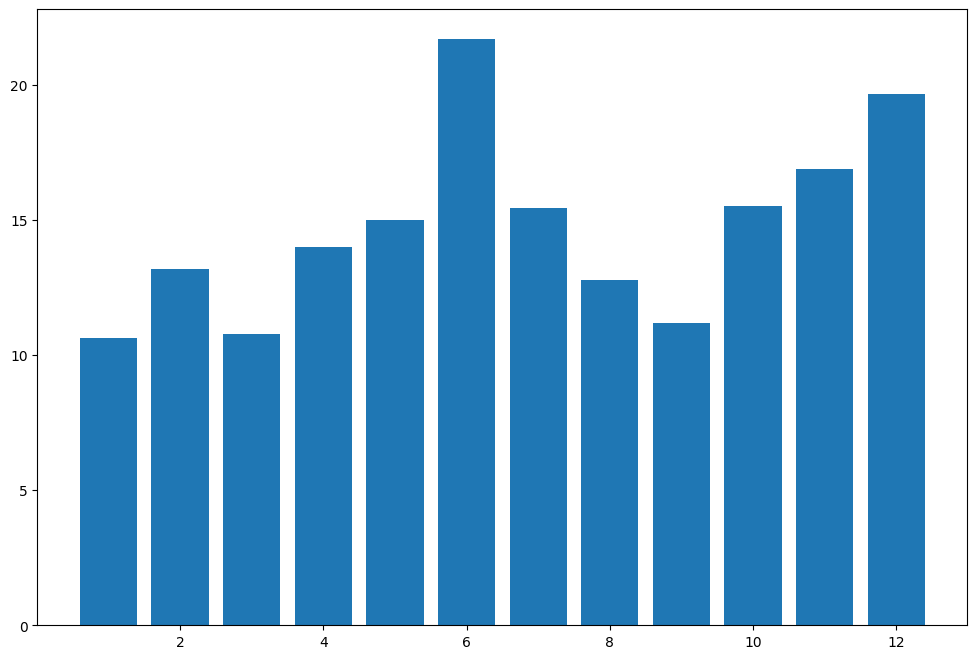

In [67]:
plt.figure(figsize=(12, 8))
plt.bar(list_months, list_count_perturbation)
plt.show()

In [68]:
# Ici je vais comparer la régularité des trains par rapport au nombre d'objet déclaré perdu par mois
# df5 contient les objets déclaré perdu pendant l'année 2019
df5 = donneAnneprecis

df5.groupBy('month').count().orderBy('count').show()
#le tableau ci dessous se lit de la maniére suivante: en mois de juin presque 17k objets on ete déclaré perdu
# Le but est de faire un graphe d'evolution de deux lignes pour comparer entre les mois 
# et cela entre les dataframe df5 et mydataTrain

+-----+-----+
|month|count|
+-----+-----+
|   12| 7596|
|    2|14181|
|   11|15264|
|    3|15325|
|    5|15733|
|    1|15809|
|    8|16130|
|    4|16262|
|   10|16575|
|    9|16736|
|    6|16978|
|    7|18476|
+-----+-----+

